# Homework 6: Percentiles, Bootstrap, A/B Testing

## Due Friday May 21st at 11:59pm

Welcome to Homework 6! This week, we will go over percentiles, bootstrapping, and permutation tests. You can find additional help on these topics in [Chapter 07](https://eldridgejm.github.io/dive_into_data_science/07-hypothesis_testing/2_permutation_tests.html) and [Chapter 08](https://eldridgejm.github.io/dive_into_data_science/08-estimation/1_bootstrap.html) of the textbook.

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

In [1]:
# Don't change this cell; just run it. 
import numpy as np
import babypandas as bpd
import math
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

import otter
grader = otter.Notebook('tests')

### Instructions

This assignment is due Friday, May 21st at 11:59pm. You are given six slip days thoughout the quarter which can extend the deadline by one day. See the syllabus for more details. With the exception of using slip days, late work will not be accepted unless you have made special arrangements with your instructor.

Please be aware of your slip days using the [Slip Day Tracker](https://docs.google.com/spreadsheets/d/197hILI-vHs-OCws3-XkLV31X8s1rdWgM-ArTrwFmU60/edit#gid=0).

You should start early so that you have time to get help if you're stuck. You may attend any Tutor's Office Hours. The calendar and links are available on Canvas.

**Important**: The `otter` tests don't usually tell you that your answer is correct. More often, they help catch careless mistakes. It's up to you to ensure that your answer is correct. If you're not sure, ask someone (not for the answer, but for some guidance about your approach).

Remember that you may work in pairs for this assignment! If you work in a pair, you must submit one notebook to Gradescope for the both of you.

Directly sharing answers between groups is not okay, but discussing problems with the course staff or with other students is encouraged. 

## 1. Ramen Ratings

<img src="data/ramen.jpeg" alt="ramen bowl" width="400"/>

In this section, we will be using a ramen rating dataset to practice A/B (permutation) testing. The dataset can be found on [Kaggle](https://www.kaggle.com/residentmario/ramen-ratings), but the data has been cleaned and condensed for the purposes of this question. We appreciate any ramen recommendations from students! We would love to hear about your favorite ramen restaurants.

The ramen data is recorded in a CSV file called `ramen.csv`. It contains five columns: `Brand`, `Variety`, `Style`, `Country`, `Stars`. Read this file into a dataframe called `ramen`.

|Column|Description|
|------|-----------|
|Brand|Ramen Brand Name|
|Variety|The Product Name within the Brand|
|Style|Cup or Pack Ramen|
|Country|Country where the Ramen is Sold|
|Stars|Quality rating on a scale of 5 stars|

In [2]:
ramen = bpd.read_csv('data/ramen.csv')
ramen

,Brand,Variety,Style,Country,Stars
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00
2,Nissin,Cup Noodles Chicken Vegetable,Cup,United States of America,2.25
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
4,Ching's Secret,Singapore Curry,Pack,India,3.75
...,...,...,...,...,...
1973,Vifon,Nam Vang,Pack,Vietnam,2.50
1974,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1.00
1975,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2.00
1976,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2.00


We will also be using a dataset that contains country names, codes and the continent they belong in. This dataset can be found [here](https://datahub.io/JohnSnowLabs/country-and-continent-codes-list), but we have cleaned the dataset for this question so information matches with the `ramen` dataset.
The country data is recorded in a CSV file called `countries.csv`. It contains six columns: `Continent_Name`, `Continent_Code`, `Country_Name`, `Two_Letter_Country_Code`, `Three_Letter_Country_Code`, `Country_Number`. Read this file into a dataframe called `continents`.

In [3]:
continents = bpd.read_csv('data/countries.csv')
continents

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,Afghanistan,AF,AFG,4.0
1,Europe,EU,Albania,AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,Algeria,DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0
...,...,...,...,...,...,...
248,Africa,AF,Zambia,ZM,ZMB,894.0
249,Oceania,OC,Disputed Territory,XX,NaN,NaN
250,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN,NaN
251,Asia,AS,United Nations Neutral Zone,XD,NaN,NaN


**Question 1.1.** Which country in the `ramen` dataset has the **third** highest average Star rating? Assign the name of this country to `third_highest`. How many `ramen` entries are there for this country? Assign this number to `count_third_highest`.

In [4]:
third_highest = ramen.groupby('Country').mean().sort_values(by='Stars', ascending=False).index[2]
count_third_highest = ramen[ramen.get('Country')==third_highest].shape[0]
third_highest, count_third_highest

('Malaysia', 148)

In [5]:
grader.check("q1_1")

q1_1 passed!

**Question 1.2.** Assign `ramen_w_continent` to a dataframe that has the continent name (*not* continent code) for each ramen entry from `ramen`. Your dataframe **must** have the columns in this order: `Brand`, `Variety`, `Style`, `Country`, `Continent`, `Stars`.

In [6]:
ramen_w_continent = bpd.DataFrame().assign(
    Brand=ramen.get("Brand"), 
    Variety=ramen.get("Variety"), 
    Style=ramen.get("Style"), 
    Country=ramen.get("Country"), 
    #Continent=ramen.get("Style"), 
    Stars=ramen.get("Stars")
) 
ramen_w_continent = ramen_w_continent.merge(continents, left_on = 'Country', right_on= 'Country_Name')
ramen_w_continent = ramen_w_continent.drop(
    columns = ['Continent_Code','Country_Name','Two_Letter_Country_Code',
    'Three_Letter_Country_Code','Country_Number']
)
ramen_w_continent = ramen_w_continent.assign(Continent=ramen_w_continent.get('Continent_Name'))
ramen_w_continent = ramen_w_continent.drop(columns='Continent_Name').assign(star=ramen_w_continent.get('Stars'))
ramen_w_continent = ramen_w_continent.drop(columns='Stars')
ramen_w_continent = ramen_w_continent.assign(Stars=ramen_w_continent.get('star'))
ramen_w_continent = ramen_w_continent.drop(columns='star')
ramen_w_continent

,Brand,Variety,Style,Country,Continent,Stars
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,Asia,3.75
1,Acecook,Spice Deli Tantan Men With Cilantro,Cup,Japan,Asia,4.00
2,Ripe'n'Dry,Hokkaido Soy Sauce Ramen,Pack,Japan,Asia,0.25
3,Fujiwara,Hokkaido Hakodate Shoyu Ramen,Pack,Japan,Asia,4.00
4,Sokensha,Curry Udon,Pack,Japan,Asia,3.50
...,...,...,...,...,...,...
1973,Vifon,Pomidorowa (Mild Tomato),Pack,Poland,Europe,4.00
1974,Amino,Zurek,Pack,Poland,Europe,3.25
1975,Golden Mie,Vegetable,Pack,United Arab Emirates,Asia,3.75
1976,Golden Mie,chicken,Pack,United Arab Emirates,Asia,3.25


In [7]:
grader.check("q1_2")

q1_2 passed!

**Question 1.3.** Now that you have the continent names for each ramen, calculate the difference between the mean star ratings of ramen from Asia and South America. Assign your answer to `diff_asia_sa`.

$$\text{diff_asia_sa} = \text{mean Asia stars} - \text{mean South America stars}$$

In [8]:
mean_asia_stars = ramen_w_continent.groupby('Continent').mean().loc['Asia']
mean_soamerica_stars = ramen_w_continent.groupby('Continent').mean().loc['South America']
diff_asia_sa = (mean_asia_stars - mean_soamerica_stars).iloc[0]
diff_asia_sa

-0.01875183639889544

In [9]:
grader.check("q1_3")

q1_3 passed!

Based on our answer, it seems like ramen from South America has a higher average star rating than ramen from Asia. Does that mean it's better?


Probably not. We can see that there are significantly fewer ramen entries from South America than Asia, so its average is higher. There is a lot of bias when the sample size is this small. 


Since there are so many ramen entries from Asia, let's compare it to a more sizeable group: all the entries not from Asia.

**Question 1.4.** Now that you have the continent names for each ramen, using `ramen_w_continent`, calculate the difference between the mean star ratings of ramen from Asia and ramen not from Asia. Assign your answer to `observed_difference`.

$$\text{observed_difference} = \text{mean Asia stars} - \text{mean non-Asia stars}$$

*Hint*: It may help to use an intermediary variable that tells whether a ramen is from Asia or not from Asia. Just make sure not to alter `ramen_w_continent`!

In [10]:
continent_sum_table = ramen_w_continent.groupby('Continent').sum()
ramen_continent_count = continent_sum_table.assign(Count=ramen_w_continent.groupby('Continent').count().get('Stars'))
ramen_means = ramen_continent_count.assign(Mean=ramen_continent_count.get('Stars') / ramen_continent_count.get('Count'))
mean_non_asia = ramen_means.take([0,2,3,4,5]).get('Stars').sum() / ramen_means.take([0,2,3,4,5]).get('Count').sum()
observed_difference = (mean_asia_stars).iloc[0] - mean_non_asia
observed_difference

0.45646963586434053

In [11]:
grader.check("q1_4")

q1_4 passed!

**Question 1.5.** Interpret in words the number you obtained for `observed_difference` and assign either 1, 2, 3, or 4 to `q1_3`.

1. In our sample, the mean stars for Asian ramen is lower than the mean stars for non-Asian ramen by about 46 percent.
2. In our sample, the mean stars for Asian ramen is higher than the mean stars for non-Asian ramen by about 46 percent.
3. In our sample, the mean stars for Asian ramen is lower than the mean stars for non-Asian ramen by about 0.46 stars.
4. In our sample, the mean stars for Asian ramen is higher than the mean stars for non-Asian ramen by about 0.46 stars.

In [12]:
q1_5 = 4

In [13]:
grader.check("q1_5")

q1_5 passed!

Now we want to conduct an A/B test (i.e. Permutation Test) to see if it is by chance that the average star rating for the Asian ramen is greater than non-Asian ramen's average star rating, or if the Asian ramen really does have higher ratings than the non-Asian ramen. To remind you on the process of an A/B test, here is the textbook reference for the [process](https://eldridgejm.github.io/dive_into_data_science/07-hypothesis_testing/2_permutation_tests.html).

**Null hypothesis ($H_0$):** Star ratings of Asian ramen and non-Asian ramen come from the same distribution.  
**Alternative hypothesis ($H_1$/$H_a$):** Star ratings of Asian ramen is typically higher than that of non-Asian ramen.

*Hint*: To make your simulation go faster, drop the irrelevant columns before our A/B test. Make a smaller dataframe that has only the relevant columns and shuffle using that dataframe. 

**Question 1.6.** Use a permutation test to calculate 500 differences using random permutations of the data. Store your 500 differences in the `differences` array.

In [14]:
new_ramen = ramen_w_continent.drop(
    columns=['Variety','Style','Brand','Country']
)
differences = np.array([])

for i in np.arange(500):
    shuffled_ramen = new_ramen.assign(
        Shuffled_Stars = np.random.permutation(new_ramen.get('Stars'))
    )
    
    continent_sum_table = shuffled_ramen.groupby('Continent').sum()
    ramen_continent_count = continent_sum_table.assign(Count=shuffled_ramen.groupby('Continent').count().get('Shuffled_Stars'))
    ramen_means = ramen_continent_count.assign(Mean=ramen_continent_count.get('Shuffled_Stars') / ramen_continent_count.get('Count'))
    nonasian_mean = ramen_means.take([0,2,3,4,5]).get('Shuffled_Stars').sum() / ramen_means.take([0,2,3,4,5]).get('Count').sum()
    
    difference = mean_asia_stars - nonasian_mean
    differences = np.append(differences, difference)

differences

array([ 0.23309377,  0.0947527 ,  0.04759493,  0.07648124,  0.12787335,
        0.11505432,  0.12613321,  0.1322817 ,  0.08245571,  0.01754852,
        0.14405664,  0.17752532,  0.10293135,  0.14608681,  0.1247411 ,
        0.15594759,  0.07868541,  0.07381302,  0.07798936,  0.10919585,
        0.123581  ,  0.09266453,  0.09771094,  0.05942787,  0.09643483,
        0.10623762,  0.04075038,  0.11325618,  0.00954388,  0.08448588,
        0.11209609,  0.10020513,  0.13761813,  0.11406824,  0.05130722,
        0.13030954,  0.17137683,  0.12914945,  0.0147643 ,  0.07265293,
        0.09133042,  0.08170165,  0.08378982,  0.08773414,  0.08761813,
       -0.00426122,  0.12700328,  0.14620281,  0.06488031,  0.09318657,
        0.06511233,  0.13785015,  0.06812857,  0.12752532,  0.05942787,
        0.07439307,  0.06279214,  0.11546036,  0.11047196,  0.17450908,
        0.0822817 ,  0.05815177,  0.00420745,  0.14782694,  0.09747892,
        0.07450908,  0.11035595,  0.16720049,  0.14005432,  0.13

In [15]:
grader.check("q1_6")

q1_6 passed!

**Question 1.7.** Compute a p-value for the hypothesis. That is, under the null hypothesis, compute the probability that we would have obtained a difference at least as extreme as `observed_difference` by chance alone. Make sure the p-value reflects the direction in the alternative hypothesis. Assign your answer to `p_val`.

In [16]:
p_val = np.count_nonzero(differences >= observed_difference) / 500
p_val

0.0

In [17]:
grader.check("q1_7")

q1_7 passed!

**Question 1.8.** At the 5% significance level, what is your conclusion? Store the numbers of the correct statements in a list called `q1_8`.

1. We reject the null hypothesis at the 0.05 significance level.
2. We fail to reject the null hypothesis at the 0.05 significance level.
3. We accept the alternative hypothesis at the 0.05 significance level.
4. We accept the null hypothesis at the 0.05 significance level.
5. We have insufficient evidence to accept the alternative hypothesis at the 0.05 significance level.

In [18]:
q1_8 = [1,3]

In [19]:
grader.check("q1_8")

q1_8 passed!

**Question 1.9.** Suppose in this question you had shuffled the column representing the continent and kept the `Stars` column constant. 
Which of the following is a true statement? Assign `q1_9` to either 1, 2, 3, or 4 depending on the number of the correct statement.

1. Your new p-value would be 1 - (old p-value), where new p-value is with the continent column shuffled and old p-value is with `Stars` shuffled.
2. We would conclude that Asian ramen would have the same star ratings than non-Asian ramen.
3. There would be no difference in the A/B Test if we had shuffled the `Style` column instead.
4. The column for continents cannot be shuffled because it is categorical.

In [20]:
q1_9 = 3

In [21]:
grader.check("q1_9")

q1_9 passed!

## 2. Percentiles

**The General Definition**

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

![](data/percentile_example.jpg)

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is always an element of the collection. Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.
2. Find $p$% of $n$: $\frac p{100}*n$. Call that $h$. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.
3. Take the $k$th element of the sorted collection.

**Question 2.1.** Assign the number of elements in `values` to the variable `n`. Define `k` as above -- your answer should be an integer. Assign the 47th percentile of the array `values` to `forty_seventh_percentile`. You must use the variables provided for you when solving this problem. For this problem only, you may *not* use `np.percentile()`.

*Hint:* Using `math.ceil()` will round up a number to the next nearest whole number. `math` has already been imported for you.

In [22]:
# don't change the values in this array!
values = np.array([23, 76, 94, 60, 71, 35, 23, 106, 54, 86, 39, 10, 48])
values.sort()  # This line sorts the array
values

array([ 10,  23,  23,  35,  39,  48,  54,  60,  71,  76,  86,  94, 106])

In [23]:
n = len(values)
h = (47/100) * n
k = math.ceil(h)
forty_seventh_percentile = k
forty_seventh_percentile

7

In [24]:
grader.check("q2_1")

q2_1 passed!

**Question 2.2.** The csv file `mcdonalds.csv` contains some selected information on menu items taken from [kaggle](https://www.kaggle.com/mcdonalds/nutrition-facts). The columns include `Category`, `Item`, `Calories`, `Sodium`, `Total Fat`, `Carbohydrates`, `Sugars`, `Protein`. Pick the appropriate bins to plot a histogram showing the distribution of `Calories`.

In [25]:
# do not change this cell
mcd = bpd.read_csv('data/mcdonalds.csv',index_col = 0)

1. mcd_bins = np.arange(0, 200, 100)
2. mcd_bins = np.arange(0, 2000, 100)
3. mcd_bins = np.arange(0, 4000, 100)

In [26]:
q2_2 = 2
q2_2

2

In [27]:
grader.check("q2_2")

q2_2 passed!

Plot a histogram showing the distribution of `Calories` using the bins chosen from Question 2.2

<AxesSubplot:ylabel='Frequency'>

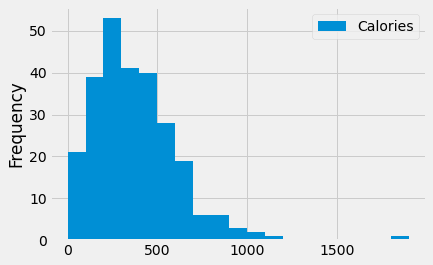

In [28]:
mcd_bins = np.arange(0,2000,100)
mcd.plot(kind='hist', y='Calories', bins=mcd_bins)

**Question 2.3.** From the plotted histogram, we notice that there is an item on the menu with a significantly larger calorie count than the rest of the menu items. Assign the outlier's item name to `item_outlier` and its calorie count to `calorie_outlier`.

In [29]:
mcd

,Category,Item,Calories,Sodium,Total Fat,Carbohydrates,Sugars,Protein
0,Breakfast,Egg McMuffin,300,750,13.0,31,3,17
1,Breakfast,Egg White Delight,250,770,8.0,30,3,18
2,Breakfast,Sausage McMuffin,370,780,23.0,29,2,14
3,Breakfast,Sausage McMuffin with Egg,450,860,28.0,30,2,21
4,Breakfast,Sausage McMuffin with Egg Whites,400,880,23.0,30,2,21
...,...,...,...,...,...,...,...,...
255,Smoothies & Shakes,McFlurry with Oreo Cookies (Small),510,280,17.0,80,64,12
256,Smoothies & Shakes,McFlurry with Oreo Cookies (Medium),690,380,23.0,106,85,15
257,Smoothies & Shakes,McFlurry with Oreo Cookies (Snack),340,190,11.0,53,43,8
258,Smoothies & Shakes,McFlurry with Reese's Peanut Butter Cups (Medium),810,400,32.0,114,103,21


In [30]:
item_outlier = mcd[mcd.get('Calories') > 1500].get('Item').iloc[0]
calorie_outlier = mcd[mcd.get('Calories') > 1500].get('Calories').iloc[0]
item_outlier, calorie_outlier

('Chicken McNuggets (40 piece)', 1880)

In [31]:
grader.check("q2_3")

q2_3 passed!

**Question 2.4.** Compare the calorie distribution between categories `Coffee & Tea` **AND** `Smoothies & Shakes` (group 1) **versus** category `Desserts` (group 2). Find the absolute difference between the 85th percentile of the two group's `Calories` column and assign it to `absolute_difference`. You may use `np.percentile()`.

In [32]:
group_1 = mcd[(mcd.get('Category') == 'Coffee & Tea') | (mcd.get('Category') == 'Smoothies & Shakes')].get('Calories')
group_2 = mcd[mcd.get('Category') == 'Desserts'].get('Calories')

calories_group_1 = np.array([])
for i in np.arange(len(group_1)):
    calories_group_1 = np.append(calories_group_1, group_1.iloc[i])
    calories_group_1 = np.sort(calories_group_1)
    
calories_group_2 = np.array([])
for i in np.arange(len(group_2)):
    calories_group_2 = np.append(calories_group_2, group_2.iloc[i])
    calories_group_2 = np.sort(calories_group_2)
    
absolute_difference = abs(np.percentile(calories_group_1, 85) - np.percentile(calories_group_2, 85))
absolute_difference

219.0

In [33]:
grader.check("q2_4")

q2_4 passed!

**Question 2.5**. In an array `carb_quartiles`, put the values for the first, second, and third quartiles (in that order) of the `Carbohydrates` data provided, but only for items not in the `Smoothies & Shakes` category. Make sure your values are in the correct order. You may use `np.percentile()`.

In [34]:
carbo_ss = mcd[mcd.get('Category') != 'Smoothies & Shakes'].get('Carbohydrates')
carbo_ss_array = np.array([])

for i in np.arange(len(carbo_ss)):
    carbo_ss_array = np.append(carbo_ss_array, carbo_ss.iloc[i])
    carbo_ss_array = np.sort(carbo_ss_array)
    
carb_quartiles =np.array([np.percentile(carbo_ss_array, 25), np.percentile(carbo_ss_array, 50), np.percentile(carbo_ss_array, 75)])
carb_quartiles

array([29., 42., 55.])

In [35]:
grader.check("q2_5")

q2_5 passed!

**Quetion 2.6.** Say that McDonald's wants to add in a new Smoothie called `Mocha Almond Fudge (Large)` which has 90 grams of sugar. What would the `Sugars` percentile range of this new smoothie be out of the **Large** only `Smoothies & Shakes` `Category`? Give the result back as two numbers (1-100). The smallest percentile that will return the new drink should be returned as `lower_bound` and the largest percentile that will return the new drink should be labeled `upper_bound`. For example, if the new smoothie would be returned back when finding the 70th percentile and 80th percentile of the Large Smoothies, but not at the 69th and 81st percentile, then lower_bound = 70, upper_bound = 80.

**Hint:** If you're unsure about percentiles, refer back to the general definition above Question 1.

In [36]:
smoothies = mcd[mcd.get('Category') == 'Smoothies & Shakes']
large_smoothies = smoothies[smoothies.get('Item').str.contains('Large')]
sugars = np.array([large_smoothies.get('Sugars')])
sugars_added = np.array([])
sugars_added = np.append(sugars, 90)
sugars_added = np.sort(sugars_added)

print(np.percentile(sugars_added, 43))
print((np.percentile(sugars_added, 44)))

lower_bound = 43
upper_bound = 44

90.11
90.88000000000001


In [37]:
grader.check("q2_6")

q2_6 passed!

**Question 2.7.** Shaun surveyed his class to find the total number of pets each of his classmates has. You can see his findings below in the table `pets`. For instance, 2 people have 0 pets, 4 have 1 pet, and so on. If one of his classmates, Jake, has some number of pets that falls in the 75th percentile of Shaun's data, how many pets does Jake have? Assign your answer to the value `jake_pets`. You may use `np.percentile()`.

*Hint*: A possible solution uses [np.repeat](https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html). (Also described in part 4.3)

In [38]:
# load the data
pets = bpd.read_csv('data/pets.csv')
pets

,Pets,Frequency
0,0,4
1,1,5
2,2,6
3,3,3
4,4,2
5,5,1
6,10,1


In [39]:
pets_data = [0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,4,4,5,10]
jake_pets = np.percentile(pets_data, 75)
jake_pets

3.0

In [40]:
grader.check("q2_7")

q2_7 passed!

## 3. In-N-Out and Five Guys

Suppose you are a burger lover and a regular at In-N-Out. When you get your third In-N-Out burger of the week, you notice that your patty is extremely small. Your friend tells you In-N-Out patties have always been this small, but you are doubtful and decide to investigate.

Ideally, you would want to figure out the exact mean weight of all In-N-Out burger patties. However, it's not feasible to obtain the mean weight of *all* In-N-Out patties (i.e. the mean weight of the population).

**Question 3.1.** Complete the statement below by filling in the blanks.

<hr style="color:Maroon;background-color:Maroon;border:0 none; height: 3px;">

Therefore, you want to collect a sample of In-N-Out patties to obtain a ____________ statistic to estimate the ____________ parameter.

<hr style="color:Maroon;background-color:Maroon;border:0 none; height: 3px;">

1. sample; population
2. population; sample

In [41]:
q3_1 = 1

In [42]:
grader.check("q3_1")

q3_1 passed!

Your other friend, who works at In-N-Out, agreed to weigh all the patties during his shift. He also does the same with Five Guys, since he works there as well. You decide to use this data as your sample.

**Question 3.2.** Your data is recorded in a CSV file called `burgers.csv`. Read this file into a table named `burgers`.

In [43]:
burgers = bpd.read_csv('data/burgers.csv')
burgers

,Place,Patty Weight (Ounces)
0,In-N-Out,2.039654
1,Five Guys,3.248876
2,In-N-Out,1.977957
3,Five Guys,3.403185
4,Five Guys,3.120933
...,...,...
95,Five Guys,3.193695
96,In-N-Out,2.061263
97,In-N-Out,2.150006
98,In-N-Out,1.739588


**Question 3.3.** For now, you only care about the weights of the In-N-Out patties. Create a new table with the rows of `burgers` where the value of `Place` is "In-N-Out". Assign this new table to `in_n_out`.

In [44]:
in_n_out = burgers[burgers.get('Place') == 'In-N-Out']
in_n_out

,Place,Patty Weight (Ounces)
0,In-N-Out,2.039654
2,In-N-Out,1.977957
5,In-N-Out,1.966266
6,In-N-Out,2.058461
8,In-N-Out,1.985435
...,...,...
93,In-N-Out,2.107875
94,In-N-Out,1.969110
96,In-N-Out,2.061263
97,In-N-Out,2.150006


In [45]:
grader.check("q3_3")

q3_3 passed!

**Question 3.4.** Calculate the mean weight of `in_n_out` patties and assign it to `in_n_out_mean`. 

In [46]:
in_n_out_mean = in_n_out.get('Patty Weight (Ounces)').mean()
in_n_out_mean

2.0076955103010907

In [47]:
grader.check("q3_4")

q3_4 passed!

You're done! Or are you? You have a single point estimate for the true mean In-N-Out patty weight. However, you don't know how uncertain your estimate is and you don't know how much these estimates could vary. In other words, you don't have a sense of how good your estimate is. You may have gotten a particular statistic for one sample, but you could also get a completely different one for another sample.

This is where the idea of resampling via the [bootstrap](http://sierra.ucsd.edu/dsc10-book/chapters/13/2/Bootstrap.html) comes in. Let's assume that our original sample resembles the population fairly well. We can then resample from our original sample to produce even more estimates, which we can then use to produce an interval estimate for the true mean weight of In-N-Out patties.

**Question 3.5.** Fill out the following code to produce 1,000 bootstrapped estimates for the  *mean* weight of In-N-Out patties. Store your 1,000 estimates in the `in_n_out_means` array.

In [48]:
in_n_out_means = np.array([])
for i in np.arange(1000):
    resample = in_n_out.sample(in_n_out.shape[0], replace=True)
    resample_mean = resample.get('Patty Weight (Ounces)').mean()
    in_n_out_means = np.append(in_n_out_means, resample_mean)

In [49]:
grader.check("q3_5")

q3_5 passed!

<AxesSubplot:ylabel='Frequency'>

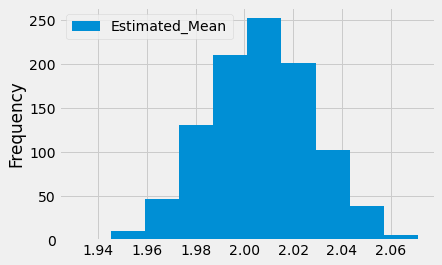

In [50]:
#: This cell displays a histogram of in_n_out_means
bpd.DataFrame().assign(Estimated_Mean = in_n_out_means).plot(kind = 'hist')

**Question 3.6.** Which of the following would make the histogram narrower? Assign either 1 or 2 to `q3_6`.
1. Starting with a larger original sample size.
2. Increasing the number of resamples (repetitions of bootstrap).

In [51]:
q3_6 = 1
q3_6

1

In [52]:
grader.check("q3_6")

q3_6 passed!

**Question 3.7.** Using the array `in_n_out_means`, compute an approximate 95% confidence interval for the true mean weight of In-N-Out patties. (Compute the lower and upper ends of the interval, named `lower_bound_in_n_out` and `upper_bound_in_n_out`, respectively.)

*Hint:* Use `percentile()`.

In [53]:
lower_bound_in_n_out = np.percentile(in_n_out_means, 2.5)
upper_bound_in_n_out = np.percentile(in_n_out_means, 97.5)

#: the confidence interval
print("Bootstrapped 95% confidence interval for the true mean weight of In-N-Out patties: [{:f}, {:f}]".format(lower_bound_in_n_out, upper_bound_in_n_out))

Bootstrapped 95% confidence interval for the true mean weight of In-N-Out patties: [1.964361, 2.048018]


In [54]:
grader.check("q3_7")

q3_7 passed!

**Question 3.8.** Suppose you want to find the weight of the heaviest In-N-Out patty (maximum weight out of the entire population). Would your bootstrap procedure be effective in estimating the weight of the heaviest In-N-Out patty?

1. Yes, a bootstrap procedure would be effective in estimating the weight of the heaviest In-N-Out patty.
2. No, a bootstrap procedure would not be effective in estimating the weight of the heaviest In-N-Out patty.

In [55]:
q3_8 = 1

In [56]:
grader.check("q3_8")

q3_8 passed!

**Question 3.9.** Suppose you're wondering how heavy the average In-N-Out patty is compared to the average Five Guys patty. Using the same bootstrap procedure, compute an approximate 95% confidence interval for the true mean difference in weight between In-N-Out and Five Guys patties. Store your 1,000 estimates in the `difference_means` array. Use the original `burgers` table for this.

$$\text{difference_mean} := \text{mean weight of In-N-Out} - \text{mean weight of Five Guys}$$

In [57]:
difference_means = np.array([])
fiveguys = burgers[burgers.get('Place') == 'Five Guys']
fiveguys_means = np.array([])
for i in np.arange(1000):
    resample = fiveguys.sample(fiveguys.shape[0], replace=True)
    resample_mean = resample.get('Patty Weight (Ounces)').mean()
    fiveguys_means = np.append(fiveguys_means, resample_mean)

    
difference_means = in_n_out_means - fiveguys_means
difference_means

array([-1.28544971, -1.26605474, -1.31595526, -1.31599478, -1.28283353,
       -1.26950673, -1.26194412, -1.27085653, -1.24897599, -1.30314267,
       -1.25227675, -1.31696377, -1.21960133, -1.24909251, -1.28621193,
       -1.25805606, -1.24632643, -1.27488845, -1.26250213, -1.27122759,
       -1.27932594, -1.31868897, -1.26450663, -1.19352489, -1.32716897,
       -1.32858565, -1.26932877, -1.3042425 , -1.34501179, -1.30220385,
       -1.31208368, -1.29751767, -1.31187363, -1.25720715, -1.28533557,
       -1.2655074 , -1.2791492 , -1.31949638, -1.31462906, -1.36195481,
       -1.30255858, -1.22509818, -1.31834494, -1.32986607, -1.26807084,
       -1.28672026, -1.30969958, -1.32279208, -1.25177898, -1.30022989,
       -1.28683956, -1.28397657, -1.28753304, -1.25887358, -1.31536519,
       -1.26066031, -1.29367874, -1.280809  , -1.38091707, -1.30031535,
       -1.32629111, -1.27379497, -1.29070403, -1.32530913, -1.25286249,
       -1.31039567, -1.33479939, -1.24131913, -1.33555617, -1.29

In [58]:
grader.check("q3_9")

q3_9 passed!

<AxesSubplot:ylabel='Frequency'>

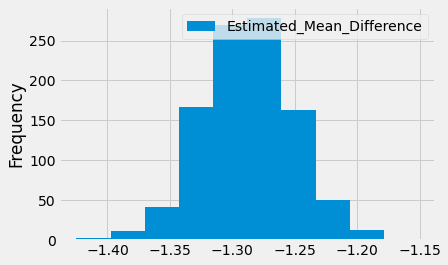

In [59]:
# This cell displays a histogram of difference_means
bpd.DataFrame().assign(Estimated_Mean_Difference = difference_means).plot(kind = 'hist')

**Question 3.10.** Compute the 95% confidence interval for the mean difference in weights of In-N-Out and Five Guys patties. Assign the left and right endpoints to `left_endpoint` and `right_endpoint` respectively. 

In [60]:
left_endpoint = np.percentile(difference_means, 2.5)
right_endpoint = np.percentile(difference_means, 97.5)

print("Bootstrapped 95% confidence interval for the mean difference in weights of In-N-Out and Five Guys patties: [{:f}, {:f}]".format(left_endpoint, right_endpoint))

Bootstrapped 95% confidence interval for the mean difference in weights of In-N-Out and Five Guys patties: [-1.359228, -1.218693]


In [61]:
grader.check("q3_10")

q3_10 passed!

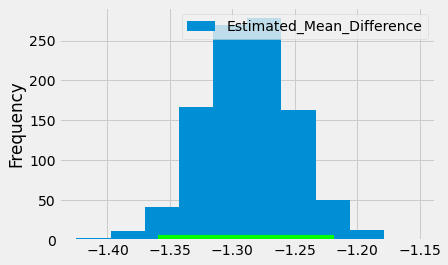

In [62]:
# This cell visualizes our 95% confidence interval on the histogram
bpd.DataFrame().assign(Estimated_Mean_Difference = difference_means).plot(kind = 'hist')
plt.plot([left_endpoint, right_endpoint], [0, 0], color='lime', linewidth=10)

**Question 3.11:** Based on your histogram and confidence interval, would you say that the mean In-N-Out patty is likely to be lighter than the mean Five Guys patty?

1. Yes, it is likely that the mean In-N-Out patty is lighter than the mean Five Guys patty.
2. No, it is not likely that the mean In-N-Out patty is lighter than the mean Five Guys patty.

In [63]:
q3_11 = 1

In [64]:
grader.check("q3_11")

q3_11 passed!

**Question 3.12.** Would changing the units of weight from ounces to grams change your conclusion? Assign a boolean (`True` if it would and `False` otherwise) to the variable `q3_12`.

In [65]:
q3_12 = False

In [66]:
grader.check("q3_12")

q3_12 passed!

# 4. Conceptual Questions

**Question 4.1.** Choose the best test (hypothesis, permutation (A/B), bootstrap) to test the following: <br>
You claim that the proportion of students from Socal that likes In-N-Out over five guys is higher than the proportion of students from Norcal that likes In-N-Out.
1. hypothesis testing
2. permutation (A/B) testing
3. bootstrap

In [67]:
q4_1 = 1

In [68]:
grader.check("q4_1")

q4_1 passed!

**Question 4.2.** Which test statistic(s) could we use to test the claim from 4.1? Put all that are valid into a list.
1. the number of Norcal students that likes In-N-Out over the total number of students that likes In-N-Out
2. the difference between the proportion of Norcal students that likes In-N-Out and proportion of Socal students that likes In-N-Out
3. total variation distance between the proportion of Norcal students that likes In-N-Out from Norcal and proportion of Socal students that likes In-N-Out


In [69]:
q4_2 = [2,3]

In [70]:
grader.check("q4_2")

q4_2 passed!

**Question 4.3.** Choose the best test (hypothesis, permutation (A/B), bootstrap) to test the following: <br>
You claim that the proportion of students that prefer Norcal burgers over Socal burgers is less than the proportion of students that prefer Socal burgers.
1. hypothesis testing
2. permutation (A/B) testing
3. bootstrap

In [71]:
q4_3 = 2

In [72]:
grader.check("q4_3")

q4_3 passed!

**Question 4.4.** Which test statistic(s) could we use to test the claim from 4.3? Put all that are valid into a list.
1. the number of students that prefer Norcal burgers over total number of students
2. the difference between the proportion of students that prefer Norcal burgers and proportion of students that prefer Socal burgers
3. total variation distance between the proportion of students that prefer Norcal burgers and proportion of students that prefer Socal burgers

In [73]:
q4_4 = [1]

In [74]:
grader.check("q4_4")

q4_4 passed!

**Question 4.5.** Choose the best test (hypothesis, permutation (A/B), bootstrap) to test the following:
You want to find the true median number of weekly burgers consumed by a student.
1. hypothesis testing
2. permutation (A/B) testing
3. bootstrap

In [75]:
q4_5 = 3

In [76]:
grader.check("q4_5")

q4_5 passed!

**Question 4.6.** After peforming bootstrapping, we construct several 95% confidence intervals. Which of the following is true about the confidence intervals?

1. The true parameter has a roughly 95% chance of falling in a confidence interval.
2. Roughly 95% of the population lie within the confidence intervals.
3. Roughly 95% of the confidence intervals constructed capture the true parameter. 

In [77]:
q4_6 = 3

In [78]:
grader.check("q4_6")

q4_6 passed!

**Question 4.7.** Which of the follow choices best describes the purpose of the permutation test with regards to A/B testing? Assign either 1, 2, or 3 to `q4_7`.
1. The permutation test is a special case of the bootstrap and allows us to produce interval estimates.
2. The permutation test generates a null distribution which we can use in testing our hypothesis.
3. The permutation test mitigates noise in our data by generating new permutations of the data.

In [79]:
q4_7 = 1

In [80]:
grader.check("q4_7")

q4_7 passed!

**Question 4.8.** An A/B test in a Randomized Controlled Trial (RCT) supports causality. Assign a boolean (`True` if it would and `False` otherwise) to the variable `q4_8`.

In [81]:
q4_8 = True

In [82]:
grader.check("q4_8")

q4_8 passed!

# Finish Line

Congratulations! You are done with homework 6.

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.

In [83]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q1_1 passed!

q1_2 passed!

q1_3 passed!

q1_4 passed!

q1_5 passed!

q1_6 passed!

q1_7 passed!

q1_8 passed!

q1_9 passed!

q2_1 passed!

q2_2 passed!

q2_3 passed!

q2_4 passed!

q2_5 passed!

q2_6 passed!

q2_7 passed!

q3_1 passed!

q3_10 passed!

q3_11 passed!

q3_12 passed!

q3_3 passed!

q3_4 passed!

q3_5 passed!

q3_6 passed!

q3_7 passed!

q3_8 passed!

q3_9 passed!

q4_1 passed!

q4_2 passed!

q4_3 passed!

q4_4 passed!

q4_5 passed!

q4_6 passed!

q4_7 passed!

q4_8 passed!